# Task 2

In [1]:
import time
import warnings
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from sklearn import preprocessing, tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

warnings.filterwarnings("ignore")


In [2]:
# load the dataset
df = pd.read_csv("project/resources/Hotels_data_Changed.csv")
# validates that there are no null values in the dataset
if df.isnull().values.any():
    print("NOTICED: there are some values that are 'NaN' in the dataset")


# Data Preparation

In [3]:
def drop_outliers(df, field_name):
    Q1 = 25
    Q3 = 75
    print("Removing data outliers by column name:", field_name)
    distance = 1.5 * (np.percentile(df[field_name], Q3) - np.percentile(df[field_name], Q1))
    df.drop(df[df[field_name] > distance + np.percentile(df[field_name], Q3)].index, inplace=True)
    df.drop(df[df[field_name] < np.percentile(df[field_name], Q1) - distance].index, inplace=True)


len_before = len(df)
field = 'DiscountPerc'
drop_outliers(df, field)
print("Number of rows after removing outliers: {}, down by {}%".format(len(df),
                                                                       round((len_before - len(df)) / len_before * 100),
                                                                       2))


Removing data outliers by column name: DiscountPerc
Number of rows after removing outliers: 177121, down by 6%


In [4]:
used_features = [
    "WeekDay",
    "Snapshot Date",
    "Checkin Date",
    "DayDiff",
    "Hotel Name"
]
len_before = len(df)
idx = df.groupby(used_features, sort=False)['DiscountPerc'].transform(max) == df['DiscountPerc']
df = df[idx]
print("Number of rows after GroupBy the data to take maximum discount price: {}, down by {}%".format(len(df),
                                                                                                     round((
                                                                                                                   len_before - len(
                                                                                                               df)) / len_before * 100),
                                                                                                     2))


Number of rows after GroupBy the data to take maximum discount price: 113144, down by 36%


In [5]:
# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
# integer encode
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
integer_encoded = df.apply(le.fit_transform)

# apply the values into the original data
for row in integer_encoded[used_features]:
    df[row] = integer_encoded[row]


In [6]:
# make sure 'Discount Code' type is int64
y = df["Discount Code"].astype(int)

# Split dataset in training and test datasets
X_train, X_test, y_train, y_test = train_test_split(df[used_features], y, test_size=0.3, random_state=int(time.time()))


## Naive Bayes

In [7]:
# Instantiate the classifier
model = GaussianNB()


# Train classifier
model.fit(X_train, y_train)
# predict the class for the data instances.
y_pred = model.predict(X_test)


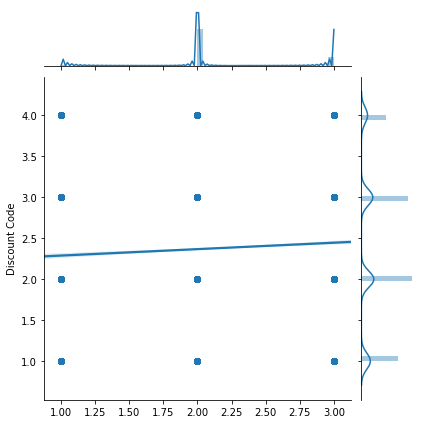

In [8]:
sns.jointplot(y_pred, y_test, kind="reg")


In [9]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.23      0.02      0.04      7808
           2       0.32      0.79      0.45     10807
           3       0.33      0.21      0.26      9945
           4       0.00      0.00      0.00      5384

   micro avg       0.32      0.32      0.32     33944
   macro avg       0.22      0.26      0.19     33944
weighted avg       0.25      0.32      0.23     33944



FP (False Positive) =  23168  FN (False Negative) =  23168
Naive Bayes Accuracy: 31.75


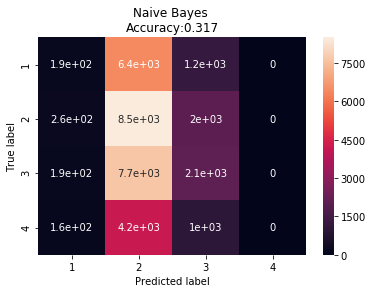

In [10]:

CM = confusion_matrix(y_test, y_pred)
FP = CM.sum(axis=0) - np.diag(CM)  
FN = CM.sum(axis=1) - np.diag(CM)
TP = np.diag(CM)
TN = CM.sum() - (FP + FN + TP)

FP_nb = FP.sum()
FN_nb = FN.sum()


print("FP (False Positive) = ", FP_nb, " FN (False Negative) = ", FN_nb)

# Overall accuracy
print("Naive Bayes Accuracy: {0:.2f}".format((accuracy_score(y_test, y_pred)) * 100))

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index=[1, 2, 3, 4], columns=[1, 2, 3, 4])

plt.figure()
sns.heatmap(cm_df, annot=True)
plt.title('Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Decision Tree Classifier

In [11]:
# Instantiate the classifier
model = tree.DecisionTreeClassifier()

# Train classifier
model.fit(X_train, y_train)
model.feature_importances_

# predict the class for the data instances.
y_pred = model.predict(X_test)


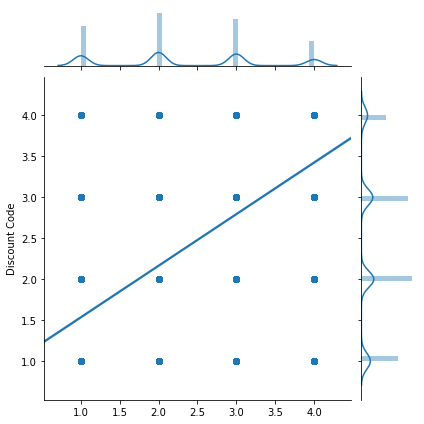

In [12]:
sns.jointplot(y_pred, y_test, kind="reg")


In [13]:
print(classification_report(y_test, y_pred))  


              precision    recall  f1-score   support

           1       0.68      0.72      0.70      7808
           2       0.72      0.73      0.73     10807
           3       0.75      0.73      0.74      9945
           4       0.71      0.67      0.68      5384

   micro avg       0.72      0.72      0.72     33944
   macro avg       0.71      0.71      0.71     33944
weighted avg       0.72      0.72      0.72     33944



FP (False Positive) =  9608  FN (False Negative) =  9608
Decision Tree Classifier Accuracy: 71.69


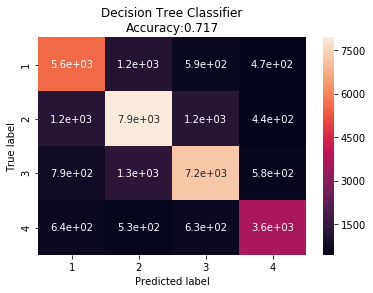

In [14]:

CM = confusion_matrix(y_test, y_pred)
FP = CM.sum(axis=0) - np.diag(CM)  
FN = CM.sum(axis=1) - np.diag(CM)
TP = np.diag(CM)
TN = CM.sum() - (FP + FN + TP)

FP_nb = FP.sum()
FN_nb = FN.sum()


print("FP (False Positive) = ", FP_nb, " FN (False Negative) = ", FN_nb)

# Overall accuracy
print("Decision Tree Classifier Accuracy: {0:.2f}".format((accuracy_score(y_test, y_pred)) * 100))

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index=[1, 2, 3, 4], columns=[1, 2, 3, 4])

plt.figure()
sns.heatmap(cm_df, annot=True)
plt.title('Decision Tree Classifier\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


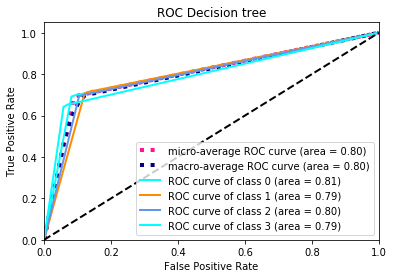

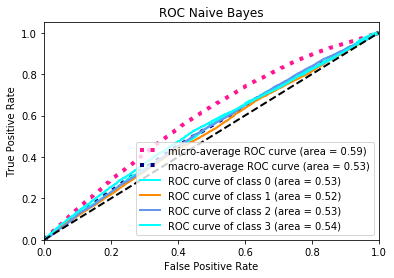

In [18]:
# הראו באמצעות מדדים סטטיסטיים את איכות התוצאות (ROC, FP, FN)
# Reference URL: https://scikit-learn.org/0.15/auto_examples/plot_roc.html


X_raw = df[used_features]
X_train, X_test, Y_train, Y_test = train_test_split(X_raw, df["Discount Code"], test_size=0.3)


# ROC
classifiers = {"ROC Decision tree": (OneVsRestClassifier(DecisionTreeClassifier())),
               "ROC Naive Bayes": (OneVsRestClassifier(GaussianNB()))}

for text, classifier in classifiers.items():
    # Binaries the output
    y = np.array(df[["Discount Code"]])
    y = y.flatten()

    y = label_binarize(y, classes=[1, 2, 3, 4])
    n_classes = y.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3)

    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(text)
    plt.legend(loc="lower right")
    plt.show()
